In [1]:
# install the follwoing packages in the enviroment:
# python3 -m pip install pandas
# python3 -m pip install seaborn

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
import json

import os

## Hypotheses to be tested

#### As reference values to compare to, we will use demographics from ECS from agu, egu, ssa. This will give an idea of how many of the active scientists at these professional levels are represented to the peer-reviewed articles (which is the main crucial factor for career advancing and perhaps the daily goal of most academics)

FIRST GLANCES AT DATA

- % of female first authors (hists?)
- % publications with all male vs. % publications with all female authors (hists?)

CO-AUTHORSHIP ANALYSES

- When 1st author is female: % of male vs. female co-authors (bars..?)
- When 1st author is female: likelihood of last author (possibly PI) to be female vs. male 
- When 1st author is male: % of female coauthors and % of male coauthors
- When the last name is female (possible PI), is there a higher % of female co-authors vs. male ones?

JOURNAL IF ANALYSES:

- Correlation between IF and female first authors: does higher IF mean fewer female first authors?




In [2]:
# Define local paths

root = ! pwd
root = root[0]

RAW_DIR=root+"/author_allgenders/"  

if not os.path.exists(RAW_DIR):
    print("The directory {} does not exist.\nThere is no raw data for statistical analysis.".format(RAW_DIR))

In [3]:
## read all json files and create a dataframe

dfs = [] 

for _, _, files in os.walk(RAW_DIR):
    for file in files:
        with open(RAW_DIR+file) as f:
            data = json.loads(f.read())
            df = pd.json_normalize(data)
            df = df.drop(columns=['first_author','all_names', 'year', 'month', 'title', 'id'])
            dfs.append(df)

df = pd.concat(dfs, ignore_index=True)
df

,journal,all_genders,all_percent
0,GRL,"[male, male]","[0.99, 0.99]"
1,Tectp,"[male, male, male, female, male, male]","[0.99, 1.0, 1.0, 0.5, 0.98, 0.9]"
2,GEOPHYSICS,[male],[0.98]
3,Science,"[male, female, male, male, male, male, male, f...","[0.99, 0.93, 0.99, 0.99, 1.0, 1.0, 0.75, 0.93,..."
4,JGRSolidEarth,"[female, init, male, male]","[0.98, None, 1.0, 0.99]"
...,...,...,...
19355,E%26PSL,"[male, male]","[0.97, 0.99]"
19356,GRL,"[male, male]","[0.88, 0.99]"
19357,NatureGeoscience,"[female, male, male, male]","[0.98, 0.98, 1.0, 0.98]"
19358,JGRSolidEarth,"[female, male]","[0.5, 0.99]"


In [11]:
# clean some journal names

df.loc[df.journal=='E%26PSL','journal'] = 'EPSL'

df.loc[df.journal.str.contains("Bulletin"),'journal'] = 'BSSA'

df.loc[df.journal.str.contains("Seismological"),'journal'] = 'SRL'

# Include impact factor:

dict_IF = {'Nature': 42.779, 'Science': 41.845, 'NatureGeoscience': 14.480, 'EPSL': 4.823, 'GRL': 4.5, 
        'JGRSolidEarth': 3.64, 'G3': 3.28, 'SRL': 3.131, 'Tectp': 3.048, 'SolidEarth': 2.921, 
       'GEOPHYSICS': 2.793, 'GJI': 2.574, 'BSSA': 2.274, 'PEPI': 2.237}

df['IF'] = df['journal'].map(dict_IF)
df

,journal,all_genders,all_percent,IF,Number_authors,First_Author_gend,First_Author_perc,Last_Author_gend,Last_Author_perc,Last_Author_probF,First_Author_probF,Prob_atleast_Fauthor,Prob_atleast_Mauthor,P_atleast_F_journal,P_atleast_M_journal
0,GRL,"[male, male]","[0.99, 0.99]",4.500,2,male,0.99,male,0.99,0.01,0.01,0.019900,0.9999,0.572646,0.965918
1,Tectp,"[male, male, male, female, male, male]","[0.99, 1.0, 1.0, 0.5, 0.98, 0.9]",3.048,6,male,0.99,male,0.90,0.10,0.01,0.563410,1.0000,0.632086,0.966387
2,GEOPHYSICS,[male],[0.98],2.793,1,male,0.98,male,0.98,0.02,0.02,0.020000,0.9800,0.434066,0.980851
3,Science,"[male, female, male, male, male, male, male, f...","[0.99, 0.93, 0.99, 0.99, 1.0, 1.0, 0.75, 0.93,...",41.845,48,male,0.99,male,0.99,0.01,0.01,1.000000,1.0000,0.771914,0.984639
4,JGRSolidEarth,"[female, init, male, male]","[0.98, None, 1.0, 0.99]",3.640,4,female,0.98,male,0.99,0.01,0.98,0.980200,1.0000,0.603106,0.971520
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19355,EPSL,"[male, male]","[0.97, 0.99]",4.823,2,male,0.97,male,0.99,0.01,0.03,0.039700,0.9997,0.634317,0.982283
19356,GRL,"[male, male]","[0.88, 0.99]",4.500,2,male,0.88,male,0.99,0.01,0.12,0.128800,0.9988,0.572646,0.965918
19357,NatureGeoscience,"[female, male, male, male]","[0.98, 0.98, 1.0, 0.98]",14.480,4,female,0.98,male,0.98,0.02,0.98,0.980792,1.0000,0.652590,0.987392
19358,JGRSolidEarth,"[female, male]","[0.5, 0.99]",3.640,2,female,0.50,male,0.99,0.01,0.50,0.505000,0.9950,0.603106,0.971520


### Create new columns in the dataframe extracting useful information from list of coauthors

In [5]:
# Number of authors:

df['Number_authors'] = df['all_genders'].apply(lambda x: len(x)) #take the length of the list all_genders

# First author's gender and percentage:

df['First_Author_gend'] = df['all_genders'].apply(lambda x: x[0]) #take the first element of the list all_genders
df['First_Author_perc'] = df['all_percent'].apply(lambda x: x[0])

# Last author's gender and percentage:

df['Last_Author_gend'] = df['all_genders'].apply(lambda x: x[-1]) #take the last element of the list all_genders
df['Last_Author_perc'] = df['all_percent'].apply(lambda x: x[-1])

df

,journal,all_genders,all_percent,IF,Number_authors,First_Author_gend,First_Author_perc,Last_Author_gend,Last_Author_perc
0,GRL,"[male, male]","[0.99, 0.99]",4.500,2,male,0.99,male,0.99
1,Tectp,"[male, male, male, female, male, male]","[0.99, 1.0, 1.0, 0.5, 0.98, 0.9]",3.048,6,male,0.99,male,0.90
2,GEOPHYSICS,[male],[0.98],2.793,1,male,0.98,male,0.98
3,Science,"[male, female, male, male, male, male, male, f...","[0.99, 0.93, 0.99, 0.99, 1.0, 1.0, 0.75, 0.93,...",41.845,48,male,0.99,male,0.99
4,JGRSolidEarth,"[female, init, male, male]","[0.98, None, 1.0, 0.99]",3.640,4,female,0.98,male,0.99
...,...,...,...,...,...,...,...,...,...
19355,EPSL,"[male, male]","[0.97, 0.99]",4.823,2,male,0.97,male,0.99
19356,GRL,"[male, male]","[0.88, 0.99]",4.500,2,male,0.88,male,0.99
19357,NatureGeoscience,"[female, male, male, male]","[0.98, 0.98, 1.0, 0.98]",14.480,4,female,0.98,male,0.98
19358,JGRSolidEarth,"[female, male]","[0.5, 0.99]",3.640,2,female,0.50,male,0.99


 #### It is easier if the all probabilities are with respect to the same gender (female)

In [6]:
# prob(female) = 1 - prob(male)

# Prob last author female:

df['Last_Author_probF'] = df['Last_Author_perc']
df.loc[df['Last_Author_gend'] == 'male','Last_Author_probF'] = \
    1 - df.loc[df['Last_Author_gend'] == 'male','Last_Author_probF']

# Prob first author female:

df['First_Author_probF'] = df['First_Author_perc']
df.loc[df['First_Author_gend'] == 'male','First_Author_probF'] = \
    1 - df.loc[df['First_Author_gend'] == 'male','First_Author_probF']

df

,journal,all_genders,all_percent,IF,Number_authors,First_Author_gend,First_Author_perc,Last_Author_gend,Last_Author_perc,Last_Author_probF,First_Author_probF
0,GRL,"[male, male]","[0.99, 0.99]",4.500,2,male,0.99,male,0.99,0.01,0.01
1,Tectp,"[male, male, male, female, male, male]","[0.99, 1.0, 1.0, 0.5, 0.98, 0.9]",3.048,6,male,0.99,male,0.90,0.10,0.01
2,GEOPHYSICS,[male],[0.98],2.793,1,male,0.98,male,0.98,0.02,0.02
3,Science,"[male, female, male, male, male, male, male, f...","[0.99, 0.93, 0.99, 0.99, 1.0, 1.0, 0.75, 0.93,...",41.845,48,male,0.99,male,0.99,0.01,0.01
4,JGRSolidEarth,"[female, init, male, male]","[0.98, None, 1.0, 0.99]",3.640,4,female,0.98,male,0.99,0.01,0.98
...,...,...,...,...,...,...,...,...,...,...,...
19355,EPSL,"[male, male]","[0.97, 0.99]",4.823,2,male,0.97,male,0.99,0.01,0.03
19356,GRL,"[male, male]","[0.88, 0.99]",4.500,2,male,0.88,male,0.99,0.01,0.12
19357,NatureGeoscience,"[female, male, male, male]","[0.98, 0.98, 1.0, 0.98]",14.480,4,female,0.98,male,0.98,0.02,0.98
19358,JGRSolidEarth,"[female, male]","[0.5, 0.99]",3.640,2,female,0.50,male,0.99,0.01,0.50


## Now we can compute some interesting probabilities:

### Useful formulas:

Suppose $x_i$ refers to the article $i$ and $N$ is the total number of articles. Then, the probability of an article having female author is:

$$p(\text{female}) = \sum_{i}^N p(\text{female}|x_i) p(x_i). $$

If we have all the probabilities with respect to the female gender, then the probability of having a male author will be:

$$p(\text{male}) = \sum_{i}^N (1 - p(\text{female}|x_i)) p(x_i). $$

$p(x_i)$ is the probability of the article $x_i$. All articles have the same probability, therefore $p(x_i) = \frac{1}{N}$. This means that the formulas above are same as taking the average of  $p(\text{female}|x_i)$ or $(1 - p(\text{female}|x_i))$, respectively.


### Let's compute some easy statistics to start

In [7]:
print('Probability of having a female first author:', df['First_Author_probF'].sum()/df.shape[0])
print('Probability of having a male first author:', (1 - df['First_Author_probF']).sum()/df.shape[0])


print('Probability of having a female last author:', df['Last_Author_probF'].sum()/df.shape[0])
print('Probability of having a male last author:', (1 - df['Last_Author_probF']).sum()/df.shape[0])



Probability of having a female first author: 0.2661768259902
Probability of having a male first author: 0.699577306241205
Probability of having a female last author: 0.18479749172200968
Probability of having a male last author: 0.7800785413358415


#### Probabilities of having at least one male/female author in an article

Having at least one female author refers to any coauthor combination excluding the case in which all authors are male:

$$p(\text{at least 1 female}|x_i) = 1 - p(\text{all male}|x_i)$$

Computing probability for all male coauthors is easier. In the following, we drop the dependency on $x_i$ for clarity.

$$p(\text{all male}) = p(\text{male}_1)p(\text{male}_2|\text{male}_1)p(\text{male}_3|\text{male}_1,\text{male}_2)... = \prod_i^n p(\text{male}_i)$$

where n is the number of authors and the last step assumes that the gender probability of each authorship is independent of the gender of other coauthors (just to simplify the problem). 

In [8]:
#Define functions to multiply probabilities in each row

#prob at least a female author

def Prob_atleast_Fauthor(x,y):
    prod = 1
    for i,elem in enumerate(x):
        if elem == 'male':
            prod *= float(y[i]) 
        elif elem == 'female':
            prod *= 1 - float(y[i])
    return 1 - prod

#prob at least a male author

def Prob_atleast_Mauthor(x,y):
    prod = 1
    for i,elem in enumerate(x):
        if elem == 'male':
            prod *= 1 - float(y[i]) 
        elif elem == 'female':
            prod *= float(y[i])
    return 1 - prod


# Create corresponding columns:

df['Prob_atleast_Fauthor'] = df.apply(lambda x: Prob_atleast_Fauthor(x.all_genders, x.all_percent), axis=1)
df['Prob_atleast_Mauthor'] = df.apply(lambda x: Prob_atleast_Mauthor(x.all_genders, x.all_percent), axis=1)

df

,journal,all_genders,all_percent,IF,Number_authors,First_Author_gend,First_Author_perc,Last_Author_gend,Last_Author_perc,Last_Author_probF,First_Author_probF,Prob_atleast_Fauthor,Prob_atleast_Mauthor
0,GRL,"[male, male]","[0.99, 0.99]",4.500,2,male,0.99,male,0.99,0.01,0.01,0.019900,0.9999
1,Tectp,"[male, male, male, female, male, male]","[0.99, 1.0, 1.0, 0.5, 0.98, 0.9]",3.048,6,male,0.99,male,0.90,0.10,0.01,0.563410,1.0000
2,GEOPHYSICS,[male],[0.98],2.793,1,male,0.98,male,0.98,0.02,0.02,0.020000,0.9800
3,Science,"[male, female, male, male, male, male, male, f...","[0.99, 0.93, 0.99, 0.99, 1.0, 1.0, 0.75, 0.93,...",41.845,48,male,0.99,male,0.99,0.01,0.01,1.000000,1.0000
4,JGRSolidEarth,"[female, init, male, male]","[0.98, None, 1.0, 0.99]",3.640,4,female,0.98,male,0.99,0.01,0.98,0.980200,1.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19355,EPSL,"[male, male]","[0.97, 0.99]",4.823,2,male,0.97,male,0.99,0.01,0.03,0.039700,0.9997
19356,GRL,"[male, male]","[0.88, 0.99]",4.500,2,male,0.88,male,0.99,0.01,0.12,0.128800,0.9988
19357,NatureGeoscience,"[female, male, male, male]","[0.98, 0.98, 1.0, 0.98]",14.480,4,female,0.98,male,0.98,0.02,0.98,0.980792,1.0000
19358,JGRSolidEarth,"[female, male]","[0.5, 0.99]",3.640,2,female,0.50,male,0.99,0.01,0.50,0.505000,0.9950


In [9]:
print('Probability of having at least one female author in an article', 
      df['Prob_atleast_Fauthor'].sum()/df.shape[0])

print('Probability of having at least one male author in an article', 
      df['Prob_atleast_Mauthor'].sum()/df.shape[0])

print('or the opposite...')

print('Probability of having at all female authors in an article', 
      1 - df['Prob_atleast_Mauthor'].sum()/df.shape[0])

print('Probability of having at all male authors in an article', 
      1 - df['Prob_atleast_Fauthor'].sum()/df.shape[0])

Probability of having at least one female author in an article 0.5761429554370728
Probability of having at least one male author in an article 0.9666776400279522
or the opposite...
Probability of having at all female authors in an article 0.0333223599720478
Probability of having at all male authors in an article 0.42385704456292717


#### We can compute the same quantity per each journal

In [10]:

journals = df['journal'].unique() # a list of unique journal names

df['P_atleast_F_journal'] = df['Prob_atleast_Fauthor'] #initialize the columns
df['P_atleast_M_journal'] = df['Prob_atleast_Mauthor']

for i in journals: #update values for each journal
    cond = df['journal']==i
    df.loc[cond,'P_atleast_F_journal'] = df.loc[cond,'Prob_atleast_Fauthor'].sum()/df[cond].shape[0]
    df.loc[cond,'P_atleast_M_journal'] = df.loc[cond,'Prob_atleast_Mauthor'].sum()/df[cond].shape[0]
    

##### Make bar plots

(0.0, 1.0)

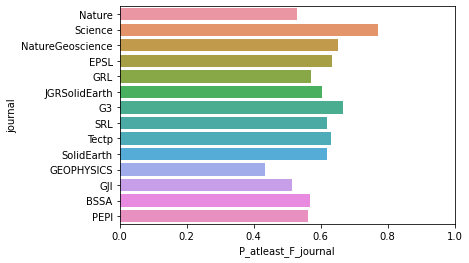

In [15]:
sns.barplot(y="journal", x="P_atleast_F_journal",  data=df, order=dict_IF.keys())
plt.xlim([0,1])

(0.0, 1.0)

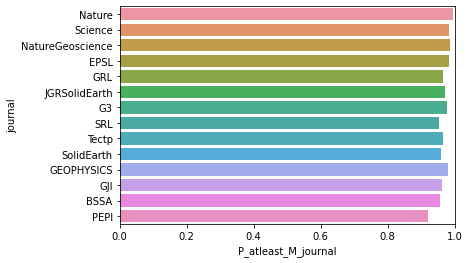

In [16]:
sns.barplot(y="journal", x="P_atleast_M_journal",  data=df,order=dict_IF.keys())
plt.xlim([0,1])

#### We should check if the numbers above are biased or are a consequence of female/male author distribution.

We can generate synthetic data using the distribution of female/male authors.


#### 1. Probability of an author being female/male:

In [13]:
def Prob_Fauthor(x,y):
    sum = 0
    for i,elem in enumerate(x):
        if elem == 'male':
            sum += 1 - float(y[i]) 
        elif elem == 'female':
            sum += float(y[i])
    return sum

def Prob_Mauthor(x,y):
    sum = 0
    for i,elem in enumerate(x):
        if elem == 'male':
            sum += float(y[i]) 
        elif elem == 'female':
            sum += 1 - float(y[i])
    return sum

df['Prob_Fauthor'] = df.apply(lambda x: Prob_Fauthor(x.all_genders, x.all_percent), axis=1)
df['Prob_Mauthor'] = df.apply(lambda x: Prob_Mauthor(x.all_genders, x.all_percent), axis=1)

df

,journal,all_genders,all_percent,Number_authors,First_Author_gend,First_Author_perc,Last_Author_gend,Last_Author_perc,Last_Author_probF,First_Author_probF,Prob_atleast_Fauthor,Prob_atleast_Mauthor,P_atleast_F_journal,P_atleast_M_journal,Prob_Fauthor,Prob_Mauthor
0,GRL,"[male, male]","[0.99, 0.99]",2,male,0.99,male,0.99,0.01,0.01,0.019900,0.9999,0.572646,0.965918,0.020000,1.980000
1,Tectp,"[male, male, male, female, male, male]","[0.99, 1.0, 1.0, 0.5, 0.98, 0.9]",6,male,0.99,male,0.90,0.10,0.01,0.563410,1.0000,0.632086,0.966387,0.630000,5.370000
2,GEOPHYSICS,[male],[0.98],1,male,0.98,male,0.98,0.02,0.02,0.020000,0.9800,0.434066,0.980851,0.020000,0.980000
3,Science,"[male, female, male, male, male, male, male, f...","[0.99, 0.93, 0.99, 0.99, 1.0, 1.0, 0.75, 0.93,...",48,male,0.99,male,0.99,0.01,0.01,1.000000,1.0000,0.771914,0.984639,14.802914,33.197086
4,JGRSolidEarth,"[female, init, male, male]","[0.98, None, 1.0, 0.99]",4,female,0.98,male,0.99,0.01,0.98,0.980200,1.0000,0.603106,0.971520,0.990000,2.010000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19355,EPSL,"[male, male]","[0.97, 0.99]",2,male,0.97,male,0.99,0.01,0.03,0.039700,0.9997,0.634317,0.982283,0.040000,1.960000
19356,GRL,"[male, male]","[0.88, 0.99]",2,male,0.88,male,0.99,0.01,0.12,0.128800,0.9988,0.572646,0.965918,0.130000,1.870000
19357,NatureGeoscience,"[female, male, male, male]","[0.98, 0.98, 1.0, 0.98]",4,female,0.98,male,0.98,0.02,0.98,0.980792,1.0000,0.652590,0.987392,1.020000,2.980000
19358,JGRSolidEarth,"[female, male]","[0.5, 0.99]",2,female,0.50,male,0.99,0.01,0.50,0.505000,0.9950,0.603106,0.971520,0.510000,1.490000


#### 2. Create some synthetic genders for authors:

In [15]:
### Define a random sampler from the distribution of female/male authors:

elements = ['female', 'male', 'init']
p1 = df['Prob_Fauthor'].sum()/df['Number_authors'].sum() #prob of an author being female
p2 = df['Prob_Mauthor'].sum()/df['Number_authors'].sum() #prob of an author being male
p3 = 1 - p1 - p2 #prob of an author being init

probabilities = [p1, p2 , p3]
np.random.choice(elements, 10, p=probabilities) # example: take 10 random samples

array(['male', 'male', 'male', 'male', 'male', 'female', 'male', 'male',
       'male', 'male'], dtype='<U6')

In [16]:
# Generate synthetic genders per each article maintaining the number of authors:

df['Synth_genders'] = df['Number_authors'].apply(lambda x: np.random.choice(elements, x, p=probabilities))
df

,journal,all_genders,all_percent,Number_authors,First_Author_gend,First_Author_perc,Last_Author_gend,Last_Author_perc,Last_Author_probF,First_Author_probF,Prob_atleast_Fauthor,Prob_atleast_Mauthor,P_atleast_F_journal,P_atleast_M_journal,Prob_Fauthor,Prob_Mauthor,Synth_genders
0,GRL,"[male, male]","[0.99, 0.99]",2,male,0.99,male,0.99,0.01,0.01,0.019900,0.9999,0.572646,0.965918,0.020000,1.980000,"[male, male]"
1,Tectp,"[male, male, male, female, male, male]","[0.99, 1.0, 1.0, 0.5, 0.98, 0.9]",6,male,0.99,male,0.90,0.10,0.01,0.563410,1.0000,0.632086,0.966387,0.630000,5.370000,"[female, male, male, male, male, male]"
2,GEOPHYSICS,[male],[0.98],1,male,0.98,male,0.98,0.02,0.02,0.020000,0.9800,0.434066,0.980851,0.020000,0.980000,[female]
3,Science,"[male, female, male, male, male, male, male, f...","[0.99, 0.93, 0.99, 0.99, 1.0, 1.0, 0.75, 0.93,...",48,male,0.99,male,0.99,0.01,0.01,1.000000,1.0000,0.771914,0.984639,14.802914,33.197086,"[male, male, male, female, female, male, male,..."
4,JGRSolidEarth,"[female, init, male, male]","[0.98, None, 1.0, 0.99]",4,female,0.98,male,0.99,0.01,0.98,0.980200,1.0000,0.603106,0.971520,0.990000,2.010000,"[male, male, male, male]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19355,EPSL,"[male, male]","[0.97, 0.99]",2,male,0.97,male,0.99,0.01,0.03,0.039700,0.9997,0.634317,0.982283,0.040000,1.960000,"[male, male]"
19356,GRL,"[male, male]","[0.88, 0.99]",2,male,0.88,male,0.99,0.01,0.12,0.128800,0.9988,0.572646,0.965918,0.130000,1.870000,"[male, male]"
19357,NatureGeoscience,"[female, male, male, male]","[0.98, 0.98, 1.0, 0.98]",4,female,0.98,male,0.98,0.02,0.98,0.980792,1.0000,0.652590,0.987392,1.020000,2.980000,"[female, male, male, female]"
19358,JGRSolidEarth,"[female, male]","[0.5, 0.99]",2,female,0.50,male,0.99,0.01,0.50,0.505000,0.9950,0.603106,0.971520,0.510000,1.490000,"[male, female]"


In [17]:
### Now check for these synthetics the probabilities:

# prob having at least one female author

def Prob_atleast_Fauthor_synth(x):
    prod = 1
    for i,elem in enumerate(x):
        if elem == 'male':
            prod *= 1 
        elif elem == 'female':
            prod *= 0
    return 1 - prod

df['Prob_atleast_Fauthor_synth'] = df.apply(lambda x: Prob_atleast_Fauthor_synth(x.Synth_genders), axis=1)

print('Probability of having at least one female author in an article', 
      df['Prob_atleast_Fauthor_synth'].sum()/df.shape[0])

# prob having at least one male author

def Prob_atleast_Mauthor_synth(x):
    prod = 1
    for i,elem in enumerate(x):
        if elem == 'male':
            prod *= 0
        elif elem == 'female':
            prod *= 1
    return 1 - prod

df['Prob_atleast_Mauthor_synth'] = df.apply(lambda x: Prob_atleast_Mauthor_synth(x.Synth_genders), axis=1)

print('Probability of having at least one male author in an article',
      df['Prob_atleast_Mauthor_synth'].sum()/df.shape[0])


Probability of having at least one female author in an article 0.6078512396694215
Probability of having at least one male author in an article 0.9646694214876033


In [18]:
### What is the prob of first and last authorships?


df['First_Author_Fperc_synth'] = df['Synth_genders'].apply(lambda x: 1 if x[0]=='female' else 0)
df['First_Author_Mperc_synth'] = df['Synth_genders'].apply(lambda x: 1 if x[0]=='male' else 0)

df['Last_Author_Fperc_synth'] = df['Synth_genders'].apply(lambda x: 1 if x[-1]=='female' else 0)
df['Last_Author_Mperc_synth'] = df['Synth_genders'].apply(lambda x: 1 if x[-1]=='male' else 0)

print('First author female:', df['First_Author_Fperc_synth'].sum()/df.shape[0])
print('First author male:', df['First_Author_Mperc_synth'].sum()/df.shape[0])
print('Last author female:', df['Last_Author_Fperc_synth'].sum()/df.shape[0])
print('Last author male:', df['Last_Author_Mperc_synth'].sum()/df.shape[0])


First author female: 0.22913223140495867
First author male: 0.7349173553719008
Last author female: 0.22355371900826446
Last author male: 0.7402892561983471
